In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import pickle
import os
import gc
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
import seaborn as sns
import time

from utilities import (
    RANDOM_STATE, TARGET_COL, N_FOLD, FOLD_STRAT_NAME, REDUCED_FOLD_NAME,
    PARAMS_LGB_BASE
)

from train import (
    train_feat_sel, feat_selection_pipeline
)

INPUT_PATH = '../input/tabular-playground-series-oct-2021'
PATH_NOTEBOOK = '../input/preprocess'

PATH_FEATURE = [
    '../input/lightgbm-feat-sel-adv-train',
    '../input/lightgbm-feat-sel-imp-gain',
    '../input/lightgbm-feat-sel-shift',
    '../input/lightgbm-feat-sel-class'
]

In [2]:
with open(os.path.join(PATH_NOTEBOOK, 'feature_dic.pkl'), 'rb') as file:
    original_feature_dic = pickle.load(file)
    
ALL_FEATURE_LIST = original_feature_dic['feature']

In [3]:
train = pd.read_pickle(
    os.path.join(PATH_NOTEBOOK, 'train_unscaled.pkl')
)

# IMPORT DEL CLASS LIST

In [4]:
possible_del_class = []

for featute_sel in PATH_FEATURE:
    with open(os.path.join(featute_sel, 'feature_dic.pkl'), 'rb') as file:
        feature_dic = pickle.load(file)
        
    possible_del_class += [x for x in ALL_FEATURE_LIST if x not in feature_dic['feature']]
    
possible_del_class = list(sorted(set(possible_del_class)))

In [5]:
#CONSTANT
FEATURE = feature_dic['feature']
CAT_COL = feature_dic['categorical']
NUMERIC_COL = feature_dic['numerical']

FOLD_LIST = list(range(N_FOLD))

gc.collect()

21

# FEATURE SELECTION PHASE
Iterate over POSSIBLE_DEL_* list and take out 1 feature at time

In [6]:
%%time
del_list = feat_selection_pipeline(data = train, feature_list = FEATURE, possible_del_list = possible_del_class,  
                            params = PARAMS_LGB_BASE, cat_col = CAT_COL, target_name = TARGET_COL, 
                            fold_strat_name = REDUCED_FOLD_NAME, new_learning_rate = .05, 
                            verbose_eval = -1, early_stopping_rounds = 5)

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[258]	validation's auc: 0.842659
Base score: 0.842659



Minute one iteration: 9.4; All iteration: 149.8



Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[258]	validation's auc: 0.842659
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[83]	validation's auc: 0.837812
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[140]	validation's auc: 0.840015
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[213]	validation's auc: 0.841818
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[247]	validation's auc: 0.843048


Feature f182 dropped. Delta AUC: 0.000390


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[191]	validation'

# TRAIN

In [7]:
del_list

['f182']

In [8]:
FEATURE = [x for x in FEATURE if x not in del_list]
CAT_COL = [x for x in CAT_COL if x not in del_list]
NUMERIC_COL = [x for x in NUMERIC_COL if x not in del_list]

feature_dic = {
    'feature': FEATURE,
    'categorical': CAT_COL,
    'numerical': NUMERIC_COL,
}

In [9]:
score = 0
model_list = []

for i, fold_ in enumerate(FOLD_LIST):

    mask_train = (train[FOLD_STRAT_NAME] != fold_)
    mask_test = (train[FOLD_STRAT_NAME] == fold_)
    
    
    train_x, train_y = train.loc[mask_train, FEATURE], train.loc[mask_train, TARGET_COL]
    test_x, test_y = train.loc[mask_test, FEATURE], train.loc[mask_test, TARGET_COL]

    model = lgb.train(
        PARAMS_LGB_BASE,
        lgb.Dataset(train_x, label=train_y,categorical_feature=CAT_COL), 100000,
        valid_sets = lgb.Dataset(test_x, label=test_y,categorical_feature=CAT_COL),
        valid_names ='validation', verbose_eval=20, early_stopping_rounds = 30,
    )
    
    #evaluate score and save model for importance/prediction
    score_fold = model.best_score['validation']['auc'] 
    score += score_fold/N_FOLD
    
    model_list.append(model)
    
    print('\nFold: {}; Auc: {:.5f}\n'.format(fold_, score_fold))
    print('-'*50)
    print('\n\n\n')
    gc.collect()
    
print('CV-Auc: {:.5f}\n'.format(score))

Training until validation scores don't improve for 30 rounds
[20]	validation's auc: 0.839391
[40]	validation's auc: 0.841858
[60]	validation's auc: 0.8445
[80]	validation's auc: 0.846309
[100]	validation's auc: 0.84768
[120]	validation's auc: 0.848984
[140]	validation's auc: 0.849713
[160]	validation's auc: 0.850186
[180]	validation's auc: 0.850615
[200]	validation's auc: 0.850807
[220]	validation's auc: 0.850995
[240]	validation's auc: 0.851105
[260]	validation's auc: 0.8512
[280]	validation's auc: 0.851237
[300]	validation's auc: 0.851215
Early stopping, best iteration is:
[283]	validation's auc: 0.851261

Fold: 0; Auc: 0.85126

--------------------------------------------------




Training until validation scores don't improve for 30 rounds
[20]	validation's auc: 0.838843
[40]	validation's auc: 0.841474
[60]	validation's auc: 0.844246
[80]	validation's auc: 0.846072
[100]	validation's auc: 0.847492
[120]	validation's auc: 0.848755
[140]	validation's auc: 0.849456
[160]	validation's

# Feature importance

In [10]:
feature_importances = pd.DataFrame()
feature_importances['feature'] = FEATURE


for fold_, model in enumerate(model_list):
    feature_importances['fold_{}'.format(fold_ + 1)] = model.feature_importance(importance_type='gain')

Text(0.5, 1.0, '50 TOP feature importance over 5 average')

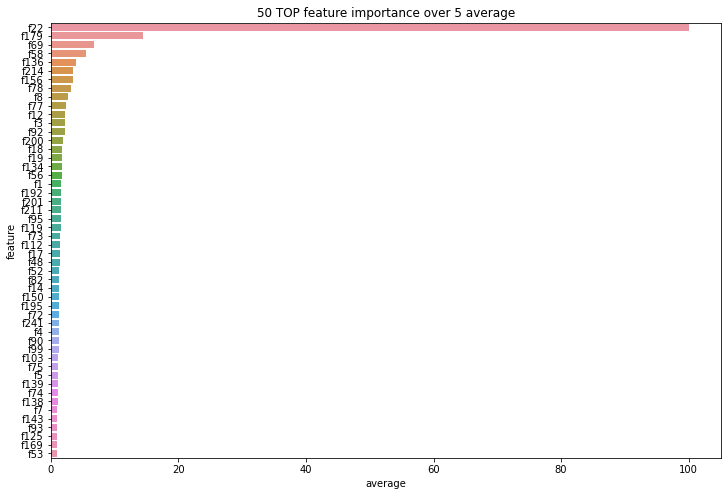

In [11]:
scaler = MinMaxScaler(feature_range=(0, 100))

average_importance = feature_importances.drop('feature', axis = 1).mean(axis=1)

feature_importances['average'] = scaler.fit_transform(X=pd.DataFrame(average_importance))
feature_importances = feature_importances.sort_values(by='average', ascending=False)

feature_importances[['feature', 'average']].to_csv('feature_importances.csv',index=False)

fig = plt.figure(figsize=(12,8))
sns.barplot(data=feature_importances.head(50), x='average', y='feature');
plt.title(f'50 TOP feature importance over {N_FOLD} average')

# TEST Blending

In [12]:
del train
gc.collect()

36

In [13]:
test = pd.read_pickle(
    os.path.join(PATH_NOTEBOOK, 'test_unscaled.pkl')
)

In [14]:
pred_test = np.zeros(test.shape[0])

for fold_, model in enumerate(model_list):
    pred_test += model.predict(test[FEATURE])/N_FOLD


# SAVE RESULT

In [15]:
#FINDED NEW FEATURE
with open('feature_dic.pkl', 'wb') as file_name:
    pickle.dump(feature_dic, file_name)

In [16]:
submission = pd.read_csv(os.path.join(INPUT_PATH, 'sample_submission.csv'))
submission['target'] = pred_test

submission.to_csv('submission.csv', index = False)